## Model building: Latent Dirichlet Allocation for uncovering latent topics in the corpus

Description: 

In section 1) Model tuning (hyperparameter selection) - decide on the number of topics (n_components) to use in the model. Run 5-fold cross validation for n_components in range (2-30). Use perplexity calculated on the test set as the evaluation criteria

In section 2) train full model with optimal number of topics determined from section 1.


LDA code was adapted from: [scikit_learn](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py) - Authors: Olivier Grisel, Lars Buitinck, Chyi-Kwei Yau - License: BSD 3 clause

In [2]:
import pandas as pd
import numpy as np
from scipy import sparse
import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

c:\Users\Nick\.conda\envs\recsys_movie\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Hyperparameter selection - determine number of topcs (n_components)

In [3]:
# read in movie database
df = pd.read_csv("data_preprocessing_eda_out\\df_spaces_upload.csv", index_col=[0])

# read in scipy sparse matrix
X = sparse.load_npz("data_preprocessing_eda_out\\X.npz")

with open("data_preprocessing_eda_out\\word_key.txt", "rb") as f:
    word_key = pickle.load(f)

n_movies = len(df)
n_features = len(word_key)

In [58]:
# no. of documents for train/test data
n_train_samples = 8000
n_test_samples = 2000

# hyperparameter selection - number of topics (n_components)
n_folds = 5
rand_seeds = [0, 11, 22, 33, 44]
n_components = np.array(
    [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
)
perp_train = np.zeros((n_components.shape[0], n_folds))
perp_test = np.zeros((n_components.shape[0], n_folds))
for k in range(n_folds):
    # construct train/test split
    print(f'fold number {k}:')
    X_train, X_test = train_test_split(
        X,
        train_size=n_train_samples,
        test_size=n_test_samples,
        random_state=rand_seeds[k],
    )
    for j, ncomp in enumerate(n_components):
        lda = LatentDirichletAllocation(
            n_components=ncomp,  # x4 components 2.5x the time
            max_iter=55,  # x2 iterations 2x the time
            learning_decay=0.55,
            learning_method="online",
            learning_offset=64.0,
            batch_size=256,
            random_state=0,
            evaluate_every=5,
            verbose=0,
            n_jobs=-1,
        )
        lda.fit(X_train)  # scales (roughly) linearly with number of training examples
        perp_train[j, k] = np.round(lda.perplexity(X_train), 1)
        perp_test[j, k] = np.round(lda.perplexity(X_test), 1)
        if(k == 0):
            pickle.dump(
                lda, open("model_building\\hyperparameter_tuning\\model_" + str(ncomp) + "_components.sav", "wb")
            )
        print(
            f"n_components = {ncomp}: p_train = {perp_train[j, k]}, p_test = {perp_test[j, k]}"
        )

with open('model_building\\perp_train.txt', 'wb') as f:
    pickle.dump(perp_train,f)   
with open('model_building\\perp_test.txt', 'wb') as f:
    pickle.dump(perp_test,f)  


n_components = 2: p_train = 3457.7, p_test = 3663.4

n_components = 3: p_train = 3235.5, p_test = 3473.8

n_components = 4: p_train = 3150.5, p_test = 3410.0

n_components = 5: p_train = 3076.7, p_test = 3350.8

n_components = 6: p_train = 3005.8, p_test = 3282.3

n_components = 7: p_train = 2940.6, p_test = 3223.7

n_components = 8: p_train = 2902.4, p_test = 3203.1

n_components = 9: p_train = 2874.1, p_test = 3188.5

n_components = 10: p_train = 2841.9, p_test = 3164.5

n_components = 11: p_train = 2814.2, p_test = 3146.0

n_components = 12: p_train = 2799.7, p_test = 3145.1

n_components = 14: p_train = 2764.2, p_test = 3132.4

n_components = 16: p_train = 2729.1, p_test = 3118.9

n_components = 18: p_train = 2726.4, p_test = 3124.8

n_components = 20: p_train = 2692.6, p_test = 3098.4

n_components = 22: p_train = 2677.3, p_test = 3096.9

n_components = 24: p_train = 2661.3, p_test = 3091.6

n_components = 26: p_train = 2650.2, p_test = 3086.6

n_components = 28: p_train = 2646.3

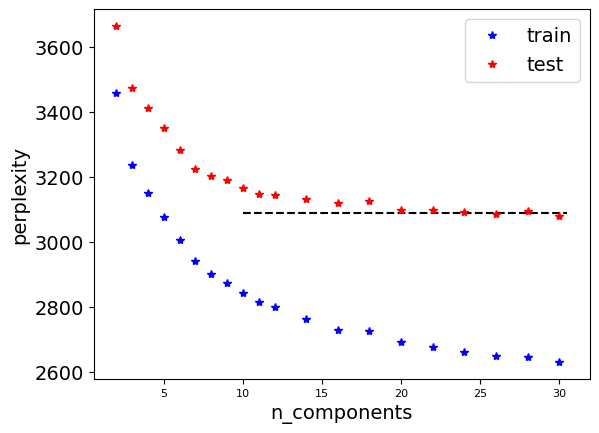

In [66]:
plt.rc("font", **{"size": 14})

fig, ax = plt.subplots(1, 1)
plt.plot(
    np.linspace(10, 30.5, 100),
    np.mean(perp_test[-4:, 2]) * np.ones(shape=(100,)),
    "k--",
)
plt.plot(n_components, perp_train[:, 2], "b*", label="train")
plt.plot(n_components, perp_test[:, 2], "r*", label="test")

ax.set_ylabel("perplexity")
ax.set_xlabel("n_components")
plt.legend()

In [69]:
fig.figure.savefig('model_building\\ncomp_tuning2.png', dpi=450, bbox_inches="tight")

## 2) Fit full model with predetermined n_components

In [17]:
# fit model with optimal value for n_components

# model inputs
n_samples = 12000
n_components = 20
n_top_words = 20

# construct train/test split
X_train, X_test = train_test_split(X, train_size=n_samples, test_size=1000, random_state=22)

# took 90 minutes (~1.75 minutes/iteration) on 10,000 words, 20 components, 10177 randomly chosen samples, 52 iterations, perplexity dropped <0.1/iteration at 52th iteration
print(
    f"Fitting LDA models with tf features, n_samples={n_samples} and n_features={n_features}..."
)
lda = LatentDirichletAllocation(
    n_components=n_components,  # x4 components 2.5x the time
    max_iter=30,  # x2 iterations 2x the time
    learning_decay=0.55,
    learning_method="online",
    learning_offset=64.0,
    batch_size=256,
    random_state=0,
    evaluate_every=5,
    verbose=1,
    n_jobs=-1
)
t0 = time.time()
lda.fit(X_train)  # scales (roughly) linearly with number of training examples
print("done in %0.3fs." % (time.time() - t0))

print(lda.perplexity(X_test))

Fitting LDA models with tf features, n_samples=8000 and n_features=10000...
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30, perplexity: 2798.1047
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30, perplexity: 2779.2717
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30, perplexity: 2772.2392
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30, perplexity: 2768.6466
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30, perplexity: 2766.3787
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteratio

In [4]:
# predict topic weights for all scripts in the database (4 minutes for the entire corpus)
# this will be precomputed and saved to be used for recommender app predicitons
Xtran = lda.transform(X)
with open('model_building\\Xtran.txt', 'wb') as f:
    pickle.dump(Xtran,f)    
pickle.dump(lda, open('model_building\\model_2023_08_24.sav', 'wb'))